<a href="https://colab.research.google.com/github/mhamza6711/RKC---methods/blob/main/RKC_method.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Problem 1.**
Solve this initial value problem
y′ = λy, y(0) = 1,
using a Runge-Kutta-Chebyshev (RKC) method.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def chebyshev_T(n, x):
    if n == 0:
        return 1.0
    if n == 1:
        return x
    T_prev, T_curr = 1.0, x
    for k in range(2, n+1):
        T_next = 2*x*T_curr - T_prev
        T_prev, T_curr = T_curr, T_next
    return T_curr

In [4]:
def compute_rkc_coeffs(s, eps=0.05):
    omega_0 = 1 + eps/s**2
    T_s = chebyshev_T(s, omega_0)
    T_s_prime = s * chebyshev_T(s-1, omega_0)

    alpha = T_s / T_s_prime

    mu = np.zeros(s)
    nu = np.zeros(s)
    kappa = np.zeros(s)

    mu[1] = alpha
    kappa[1] = alpha

    for j in range(2, s):
        tj  = chebyshev_T(j, omega_0)
        tj1 = chebyshev_T(j-1, omega_0)
        tj2 = chebyshev_T(j-2, omega_0)

        mu[j] = (2 * tj / tj1) * alpha
        nu[j] = -(tj2 / tj1)
        kappa[j] = mu[j] + nu[j]

    return mu, nu, kappa, alpha


In [5]:
def RKC_iterative(lambda_val, y0, T, dt, s):
    N = int(T/dt)
    t = np.linspace(0, T, N+1)
    y = np.zeros(N+1)
    y[0] = y0

    mu, nu, kappa, alpha = compute_rkc_coeffs(s)

    # stores all iterative stage values
    all_stages = []

    for n in range(N):
        print(f"\n==============================")
        print(f"Time step n = {n},  t = {t[n]:.4f}")
        print("==============================")

        Y_prev2 = None
        Y_prev1 = y[n]

        stages = []
        stages.append(Y_prev1)

        print(f"Stage 0: Y_0 = {Y_prev1:.8f}")

        # Stage 1
        Y_curr = Y_prev1

        # Stage 2
        Y_next = Y_prev1 + mu[1] * dt * lambda_val * Y_curr
        print(f"Stage 1: Y_1 = {Y_next:.8f}")

        stages.append(Y_next)

        # remaining stages
        for j in range(2, s):
            temp = (
                mu[j] * dt * lambda_val * Y_next
                + nu[j] * Y_prev1
                + (1 - mu[j] - nu[j]) * Y_curr
            )

            print(f"Stage {j}: Y_{j} = {temp:.8f}")

            Y_prev1, Y_curr, Y_next = Y_curr, Y_next, temp
            stages.append(temp)

        y[n+1] = Y_next
        all_stages.append(stages)

    return t, y, all_stages


In [6]:
lambda_val = -50
y0 = 1
T = 1.0
dt = 0.1
s = 5   # smaller stages => easier to see manually

t_rkc, y_rkc, stage_values = RKC_iterative(lambda_val, y0, T, dt, s)

# exact solution
y_exact = np.exp(lambda_val * t_rkc)


Time step n = 0,  t = 0.0000
Stage 0: Y_0 = 1.00000000
Stage 1: Y_1 = -0.01767251
Stage 2: Y_2 = 0.62667554
Stage 3: Y_3 = -2.31021912
Stage 4: Y_4 = 5.77330620

Time step n = 1,  t = 0.1000
Stage 0: Y_0 = 5.77330620
Stage 1: Y_1 = -0.10202883
Stage 2: Y_2 = 3.61798979
Stage 3: Y_3 = -13.33760234
Stage 4: Y_4 = 33.33106449

Time step n = 2,  t = 0.2000
Stage 0: Y_0 = 33.33106449
Stage 1: Y_1 = -0.58904366
Stage 2: Y_2 = 20.88776287
Stage 3: Y_3 = -77.00206231
Stage 4: Y_4 = 192.43044127

Time step n = 3,  t = 0.3000
Stage 0: Y_0 = 192.43044127
Stage 1: Y_1 = -3.40072940
Stage 2: Y_2 = 120.59145088
Stage 3: Y_3 = -444.55648379
Stage 4: Y_4 = 1110.95985981

Time step n = 4,  t = 0.4000
Stage 0: Y_0 = 1110.95985981
Stage 1: Y_1 = -19.63345214
Stage 2: Y_2 = 696.21137113
Stage 3: Y_3 = -2566.56070438
Stage 4: Y_4 = 6413.91144729

Time step n = 5,  t = 0.5000
Stage 0: Y_0 = 6413.91144729
Stage 1: Y_1 = -113.34993100
Stage 2: Y_2 = 4019.44142593
Stage 3: Y_3 = -14817.54082897
Stage 4: Y_4 =

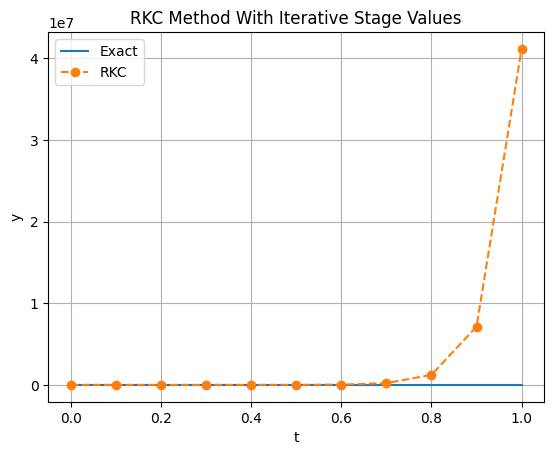

In [7]:
plt.plot(t_rkc, y_exact, label="Exact")
plt.plot(t_rkc, y_rkc, "o--", label="RKC")
plt.legend()
plt.grid()
plt.xlabel("t")
plt.ylabel("y")
plt.title("RKC Method With Iterative Stage Values")
plt.show()

# **Problem 2.**
Solve one-dimensional heat equation using RKC method:

u_t = u_xx, x ∈ (0, 1), t > 0, u(0, t) = 0, u(1, t) = 0, t > 0, u(x, 0) = sin(πx), 0 ≤ x ≤ 1.

In [8]:
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
import time
import os
from math import ceil, sqrt

In [9]:
N = 100
T = 0.1
h = 1e-3

In [10]:

# grid and Laplacian (Dirichlet)
hx = 1.0 / (N + 1)
x = np.linspace(hx, 1-hx, N)
diag = -2.0 * np.ones(N)
off = 1.0 * np.ones(N-1)
A = sp.diags([off, diag, off], offsets=[-1,0,1], format='csr') / (hx*hx)


In [11]:
U0 = np.sin(np.pi * x)

In [12]:
def exact_solution(t):
    return np.exp(-np.pi**2 * t) * np.sin(np.pi * x)

In [13]:
# time stepping setup
nsteps = int(np.ceil(T / h))
h = T / nsteps


In [14]:
lambda_max_est = 4.0 / (hx*hx)
z_max = h * lambda_max_est
s_needed = ceil(sqrt(z_max / 2.0))
s = max(3, s_needed + 2)
L = 2.0 * s * s

In [15]:
print(f"N = {N}, hx = {hx:.3e}, T = {T}, h = {h:.3e}, nsteps = {nsteps}")

N = 100, hx = 9.901e-03, T = 0.1, h = 1.000e-03, nsteps = 100


In [16]:
print(f"Estimated |lambda_max| ~ {lambda_max_est:.3e}, z_max = h*|lambda_max| = {z_max:.3e}")

Estimated |lambda_max| ~ 4.080e+04, z_max = h*|lambda_max| = 4.080e+01


In [17]:
print(f"Chosen RKC stages s = {s}, stability-length L = {L:.3e}")

Chosen RKC stages s = 7, stability-length L = 9.800e+01


In [18]:
I = sp.identity(N, format='csr')
scale = 2.0 * h / L
x_op = I + scale * A

In [19]:
def apply_chebyshev_polynomial_to_vector(v, s, x_op):
    # T_0(v) = v, T_1(v) = x_op @ v
    if s == 0:
        return v.copy()
    v0 = v.copy()
    v1 = x_op.dot(v0)
    if s == 1:
        return v1
    for k in range(1, s):
        v2 = 2.0 * x_op.dot(v1) - v0
        v0, v1 = v1, v2
    return v1

In [20]:
U = U0.copy()
times = [0.0]
errors_L2 = [np.linalg.norm(U - exact_solution(0.0))]
start_time = time.time()
for n in range(nsteps):
    U = apply_chebyshev_polynomial_to_vector(U, s, x_op)
    t = (n+1) * h
    times.append(t)
    errors_L2.append(np.linalg.norm(U - exact_solution(t)))
end_time = time.time()

In [21]:
print(f"Completed {nsteps} steps in {end_time-start_time:.4f} s. Final L2 error = {errors_L2[-1]:.3e}")

Completed 100 steps in 0.0151 s. Final L2 error = 8.508e-03


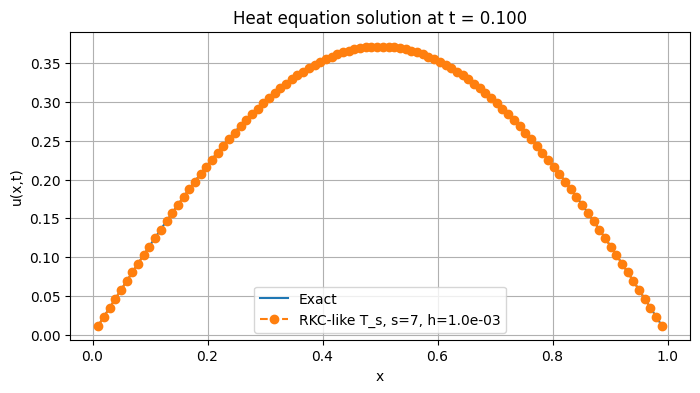

In [22]:
U_exact = exact_solution(T)
plt.figure(figsize=(8,4))
plt.plot(x, U_exact, label='Exact', linewidth=1.5)
plt.plot(x, U, marker='o', linestyle='--', label=f'RKC-like T_s, s={s}, h={h:.1e}')
plt.xlabel('x')
plt.ylabel('u(x,t)')
plt.title(f'Heat equation solution at t = {T:.3f}')
plt.legend()
plt.grid(True)
plt.show()

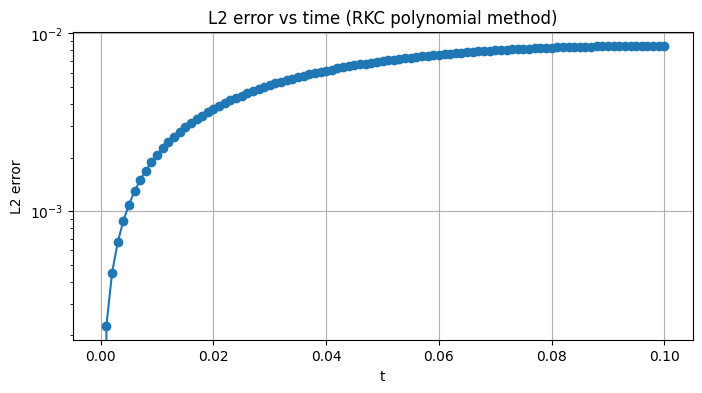

In [23]:
# Plot: L2 error vs time
plt.figure(figsize=(8,4))
plt.semilogy(times, errors_L2, marker='o')
plt.xlabel('t')
plt.ylabel('L2 error')
plt.title('L2 error vs time (RKC polynomial method)')
plt.grid(True)
plt.show()

In [24]:
idxs = [0, N//4, N//2, 3*N//4, N-1]
print("\nSample values at final time (x, U_num, U_exact, abs_err):")
for i in idxs:
    print(f"x={x[i]:.4f}, U_num={U[i]:.6e}, U_exact={U_exact[i]:.6e}, abs_err={abs(U[i]-U_exact[i]):.6e}")


Sample values at final time (x, U_num, U_exact, abs_err):
x=0.0099, U_num=1.155393e-02, U_exact=1.159116e-02, abs_err=3.723362e-05
x=0.2574, U_num=2.687540e-01, U_exact=2.696201e-01, abs_err=8.660851e-04
x=0.5050, U_num=3.714657e-01, U_exact=3.726628e-01, abs_err=1.197083e-03
x=0.7525, U_num=2.606470e-01, U_exact=2.614869e-01, abs_err=8.399593e-04
x=0.9901, U_num=1.155393e-02, U_exact=1.159116e-02, abs_err=3.723362e-05


In [25]:
outdir = "/mnt/data/rkc_heat_outputs"
os.makedirs(outdir, exist_ok=True)
np.save(os.path.join(outdir, "x.npy"), x)
np.save(os.path.join(outdir, "U_rkc.npy"), U)
np.save(os.path.join(outdir, "U_exact.npy"), U_exact)
print(f"\nSaved arrays to {outdir}.")


Saved arrays to /mnt/data/rkc_heat_outputs.
